In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
from makeCorner import *
import sys
sys.path.append("./../code/")
from piCurve import *
from matplotlib import cm
from gwBackground import *
from makeDelayedRateData import *
from scipy.special import gammainc
import population_parameters

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

# Inspect delayed SFR-tracing $R(z)$ data

The purpose of this notebook is to load and inspect the output data stored in `fixed_rate_delayedSFR_HLO1.hdf`, produced by `run_birefringence_delayedSFR_HLO1.py`.

First, we'll load the datafile:

In [2]:
data = h5py.File('fixed_rate_delayedSFR_HLO1.hdf','r')

# Print attributes
for k,v in data.attrs.items():
    print("{0}:\t\t{1}".format(k,v))
    
# Print keys
data['result'].keys()

Created_by:		run_birefringence_delayedSFR_HLO1.py
Downloadable_from:		https://zenodo.org/doi/10.5281/zenodo.10384998
Source_code:		https://github.com/tcallister/stochastic-birefringence


<KeysViewHDF5 ['kappa_dcs_1D', 'kappa_dcs_2D', 'kappa_zs_1D', 'kappa_zs_2D', 'probabilities', 'probability_kappa_dc_1D', 'probability_kappa_z_1D']>

The keys have the following definitions:

| Key | Definition |
| :-- | :--------- |
| `kappa_dcs_1D` | A grid of $\kappa_D$ values over which the posterior $p(\kappa_D|d,\kappa_z=0)$ is defined, with fixed $\kappa_z=0$|
| `probability_kappa_dc_1D` | Values of the posterior $p(\kappa_D|d,\kappa_z=0)$ defined across `kappa_dcs_1D` |
| `kappa_zs_1D` | A grid of $\kappa_z$ values over which the posterior $p(\kappa_z|d,\kappa_D=0)$ is defined, with fixed $\kappa_D=0$|
| `probability_kappa_z_1D` | Values of the posterior $p(\kappa_z|d,\kappa_D=0)$ defined across `kappa_zs_1D` |
| `kappa_dcs_2D` | A grid of $\kappa_D$ values over which a joint posterior $p(\kappa_D,\kappa_z|d)$ is defined |
| `kappa_zs_2D` | A grid of $\kappa_z$ values over which a joint posterior $p(\kappa_D,\kappa_z|d)$ is defined |
| `probabilities` | A 2D posterior $p(\kappa_D,\kappa_z|d)$, computed over the grids defined by `kappa_dcs_2D` and `kappa_zs_2D` |

Now let's plot some results.
First unpack data:

In [3]:
# Fitting only kappa_d
kappa_dcs_1D = data['result']['kappa_dcs_1D'][()]
p_kappa_dc_1D = data['result']['probability_kappa_dc_1D'][()]

# Fitting only kappa_z
kappa_zs_1D = data['result']['kappa_zs_1D'][()]
p_kappa_z_1D = data['result']['probability_kappa_z_1D'][()]

# Fitting both jointly
kappa_dcs = data['result']['kappa_dcs_2D'][()]
kappa_zs = data['result']['kappa_zs_2D'][()]
joint_probabilities = data['result']['probabilities'][()]

## 1. Posterior on $\kappa_D$, when $\kappa_z$ is fixed to zero

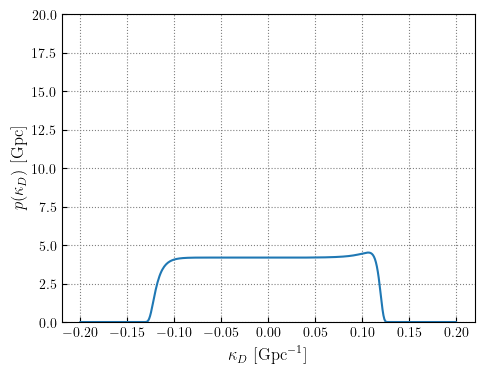

In [4]:
fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(kappa_dcs_1D,p_kappa_dc_1D,color=blue)
ax.set_xlabel('$\kappa_D$ [$\mathrm{Gpc}^{-1}$]')
ax.set_ylabel('$p(\kappa_D)$ [$\mathrm{Gpc}$]')
ax.set_ylim(0,20)
plt.show()

## 2. Posterior on $\kappa_z$, when $\kappa_D$ is fixed to zero

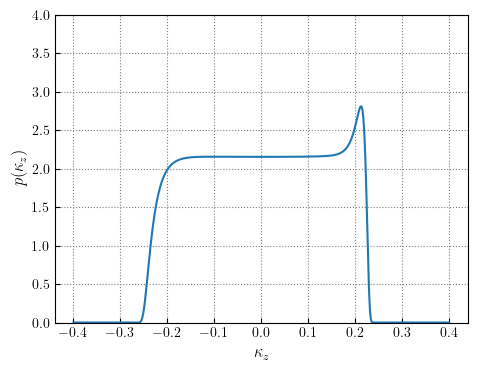

In [5]:
fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(kappa_zs_1D,p_kappa_z_1D,color=blue)
ax.set_xlabel('$\kappa_z$')
ax.set_ylabel('$p(\kappa_z)$')
ax.set_ylim(0,4.)
plt.show()

## 3. Joint posterior on $\kappa_D$ and $\kappa_z$

/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_61157/3327468091.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c = ax.pcolormesh(kappa_dcs,kappa_zs,joint_probabilities.T,cmap=cmap,vmin=1e-6)


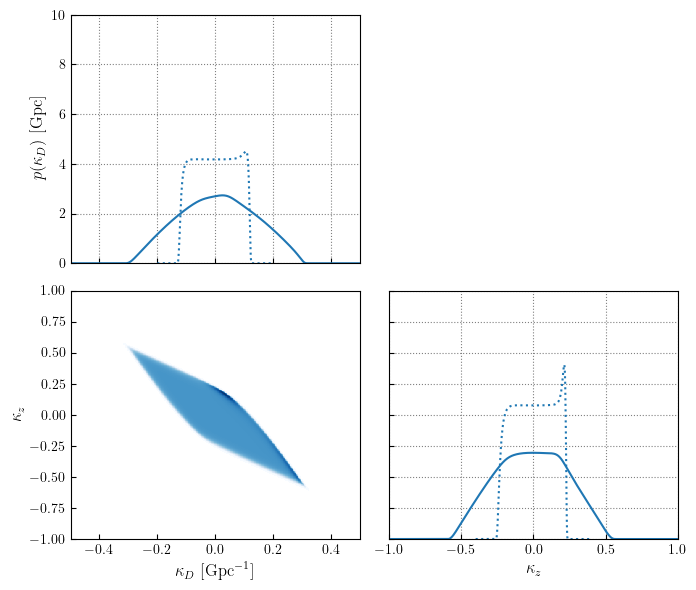

In [6]:
# For comparison to conditional distributions above, let's also compute *marginal* distributions
# over each birefringence parameter.
# First integrate over kappa_z to get marginal p(kappa_d) posterior
p_kd = np.trapz(joint_probabilities,axis=1)
p_kd /= np.trapz(p_kd,kappa_dcs)

# And integrate over kappa_D to get marginal posterior on kappa_z
p_kz = np.trapz(joint_probabilities,axis=0)
p_kz /= np.trapz(p_kz,kappa_zs)

# Set up figure
fig = plt.figure(figsize=(7,6))

# Plot 2D posterior
ax = fig.add_subplot(223)
cmap = cm.Blues
cmap.set_under("white")
c = ax.pcolormesh(kappa_dcs,kappa_zs,joint_probabilities.T,cmap=cmap,vmin=1e-6)
ax.set_xlabel('$\kappa_D$ [$\mathrm{Gpc}^{-1}$]')
ax.set_ylabel('$\kappa_z$')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-1.,1.)

# Plot 1D kappa_d posteriors (both marginal and conditional on kappa_z=0)
ax = fig.add_subplot(221)
ax.plot(kappa_dcs,p_kd)
ax.plot(kappa_dcs_1D,p_kappa_dc_1D,color=blue,ls=':')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_ylabel('$p(\kappa_D)$ [$\mathrm{Gpc}$]')

# And 1D kappa_z posteriors
ax = fig.add_subplot(224)
ax.plot(kappa_zs,p_kz)
ax.plot(kappa_zs_1D,p_kappa_z_1D,color=blue,ls=':')
ax.set_xlim(-1.,1.)
ax.set_ylim(0,4)
ax.set_yticklabels([])
ax.set_xlabel('$\kappa_z$')

plt.tight_layout()
plt.show()

## 4. Plot implied posterior on $\Omega(f)$

As a somewhat more involved exercise, we can take the above joint posterior on birefringent coefficients and map them onto a posterior on the stochastic background $\Omega_I(f)$ and $\Omega_V(f)$ spectra. This will involve first reconstructing the merger rate $R(z)$ used in the inference, and preparing a stochastic background calculator.

In [7]:
# First prepare a grid of redshifts and (arbitrarily normalized) merger rate values.
# In this case, our model a metallicity-weighted and time-delayed Madau+Dickinson SFR
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
time_delays = rateData['tds']
zs_formation = rateData['formationRedshifts']
formationRates = rateData['formationRates']

# The following function is an approximation to the integrated fraction of star formation below
# Z=Z_sun/10 as a function of redshift
low_Z_fraction = gammainc(0.84,(0.1**2.)*np.power(10.,0.3*zs_formation))

# Multiply by total formation rate to get the rate of low metallicity star formation
weightedFormationRates = formationRates*low_Z_fraction

# Convolve formation rate with time-delay distribution
# Set t_min = 10 Myr
tdMin = 0.01
dpdt = np.power(time_delays,-1)
dpdt[time_delays<tdMin] = 0.
dRdV_delayed = weightedFormationRates.dot(dpdt)
dRdV_delayed /= dRdV_delayed[0]

# Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

# Define hyperparameters describing mass distribution
R0 = population_parameters.R0
m_min = population_parameters.m_min
m_max = population_parameters.m_max
dm_min = population_parameters.dm_min
dm_max = population_parameters.dm_max
alpha = population_parameters.alpha_m
mu_peak = population_parameters.mu_peak
sig_peak = population_parameters.sig_peak
frac_peak = population_parameters.frac_peak
bq = population_parameters.bq

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,dm_min,dm_max,alpha,mu_peak,sig_peak,frac_peak,bq)

/Users/tcallister/Documents/Repositories/stochastic-birefringence/data/./../code/gwBackground.py:352: RuntimeWarning: divide by zero encountered in divide
  probs_m2 = (1.+bq)*np.power(self.m2s_2d,bq)/(np.power(self.m1s_2d,1.+bq)-2.**(1.+bq))


To translate the $\kappa_D$-$\kappa_z$ posterior above into a posterior over energy spectra, we will rejection sample across the range of $(\kappa_D,\kappa_z)$ grid points.

In [8]:
# Prepare arrays with the kappa_d vs. kappa_z coordinates for every computed posterior probability
KZ,KD = np.meshgrid(kappa_zs,kappa_dcs)
full_kappa_ds = KD.reshape(-1)
full_kappa_zs = KZ.reshape(-1)

# Unwrap joint probabilities into a corresponding 1D array
full_probabilities = joint_probabilities.reshape(-1)/np.max(joint_probabilities)

# We will use this array to keep track of which grid points we wish to keep, upon rejection sampling
to_save = np.full(full_kappa_ds.size,False)

# Loop across each grid point
from tqdm.notebook import tqdm
for i in tqdm(range(full_kappa_ds.size)):
    
    # Draw and random number; if this does not exceed posterior at the given location,
    # keep this sample
    if np.random.random()<full_probabilities[i]:
        to_save[i]=True
        
# Read out rejection-sampled points
selected_kappa_ds = full_kappa_ds[to_save]        
selected_kappa_zs = full_kappa_zs[to_save]

  0%|          | 0/159600 [00:00<?, ?it/s]

In [9]:
nDraws = 400
freqs = np.logspace(1,3.5,300)
OmgIs = np.zeros((nDraws,freqs.size))
OmgVs = np.zeros((nDraws,freqs.size))

random_inds = np.random.choice(range(selected_kappa_ds.size),size=nDraws)
for i,ind in tqdm(enumerate(random_inds)):
    
    OmgI,OmgV = omg.eval(R0,dRdV_delayed,freqs,selected_kappa_ds[ind],selected_kappa_zs[ind])
    OmgIs[i,:] = OmgI
    OmgVs[i,:] = OmgV

0it [00:00, ?it/s]

In [28]:
# Get PI curves appropriate for the HL-O1 search sensitivity
PI_freqs,HL_O1_sigmas = np.loadtxt('../input/H1L1_O1.dat',unpack=True,skiprows=1,usecols=(0,2))

# Compute the Stokes I PI curve directly
StokesI_PI = pi_curve(PI_freqs,HL_O1_sigmas,-10,10)

# For Stokes V, we will need to rescale sigmas by the ratio of Stokes I and Stokes V overlap reduction functions
# Instantiate baseline object, compute ORFs, and rescale
H1L1 = Baseline(Detector.H1(),Detector.L1())
H1L1_gammaI,H1L1_gammaV = H1L1.stokes_overlap_reduction_functions(PI_freqs)
rescaled_HL_O1_sigmas = HL_O1_sigmas*(H1L1_gammaI/H1L1_gammaV)

# Compute Stokes V PI curve
StokesV_PI = pi_curve(PI_freqs,rescaled_HL_O1_sigmas,-10,10)

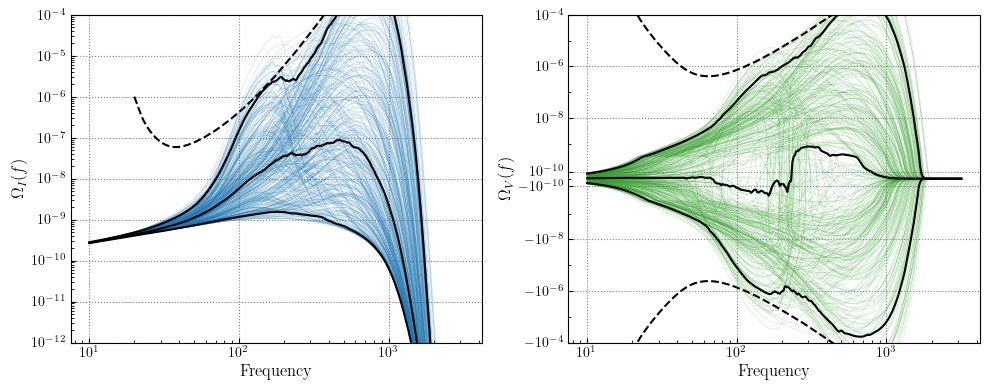

In [29]:
# Now plot!

# Set up figure
fig,axs = plt.subplots(1,2,figsize=(10,4))

###############
# Stokes I
###############

ax = axs[0]

# Plot individual traces
for i in range(nDraws):
    ax.plot(freqs,OmgIs[i,:],color=blue,lw=0.3,alpha=0.3)
    
# Plot bounds and PI curves
ax.plot(freqs,np.median(OmgIs,axis=0),color='black')
ax.plot(freqs,np.quantile(OmgIs,0.95,axis=0),color='black')
ax.plot(freqs,np.quantile(OmgIs,0.05,axis=0),color='black')
ax.plot(PI_freqs,StokesI_PI,color='black',ls='--')

# Misc formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-12,1e-4)
ax.set_xlabel('Frequency')
ax.set_ylabel('$\Omega_I(f)$')

###############
# Stokes V
###############

ax = axs[1]

# Plot individual traces
for i in range(nDraws):
    ax.plot(freqs,OmgVs[i,:],color=green,lw=0.3,alpha=0.3)
    
# Plot bounds and PI curves
ax.plot(freqs,np.median(OmgVs,axis=0),color='black')
ax.plot(freqs,np.quantile(OmgVs,0.95,axis=0),color='black')
ax.plot(freqs,np.quantile(OmgVs,0.05,axis=0),color='black')
ax.plot(PI_freqs,StokesV_PI,color='black',ls='--')
ax.plot(PI_freqs,-StokesV_PI,color='black',ls='--')

# Misc formatting
ax.set_xscale('log')
ax.set_yscale('symlog',linthresh=3e-10,linscale=0.75)
ax.set_ylim(-1e-4,1e-4)
ax.set_xlabel('Frequency')
ax.set_ylabel('$\Omega_V(f)$')
ax.set_yticks([-1e-4,-1e-6,-1e-8,-1e-10,1e-10,1e-8,1e-6,1e-4])

plt.tight_layout()
plt.show()